In [1]:
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
from VisionEngine.utils.eval import (embed_images, 
                                     reconstruct_images,
                                     reconstruct_images, 
                                     sample_likelihood)

from VisionEngine.utils.plotting import imscatter

from VisionEngine.utils.perceptual_loss import (make_perceptual_loss_model,
                                                calculate_perceptual_distances)

from VisionEngine.utils.disentanglement_score import dissentanglement_score

from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import scipy

import numba

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import pairwise_distances
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

import math

import tensorflow as tf
from tensorflow.keras.layers import Flatten

import multiprocessing
import random

In [2]:
# seed_value = 42
# random.seed(seed_value)
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GPU = 0

In [5]:
# some plotting params
plt.rcParams['pdf.use14corefonts'] = True

In [6]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/butterflies_nouveau/2020-229-11/butterflies_nouveau.hdf5"
# checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau/2020-228-16/guppy_nouveau.hdf5"
# checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/celeba_nouveau/2020-230-13/celeba_nouveau.hdf5"
# checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_finetune/2020-230-11/guppy_nouveau_finetune.hdf5"
checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_real/2020-237-17/guppy_nouveau_real.hdf5"

In [8]:
# config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/butterfly_nouveau_config.json"
# config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/celeba_nouveau_config.json"
# config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_nouveau_finetune_config.json"
# config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_nouveau_config.json"
config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_nouveau_real_config.json"

config = process_config(config_file)

In [9]:
with tf.device(f'/device:GPU:{GPU}'):
    model = factory.create(
                "VisionEngine.models."+config.model.name
                )(config)

importing VisionEngine.models.nouveau_vae_model
getattr VAEModel
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
noise_layer (Sequential)        (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
encoder (Model)                 [(None, 524288), (No 38380171    noise_layer[0][0]                
__________________________________________________________________________________________________
variational_layer (VariationalL (None, 10)           5242890     encoder[1][0]                    
______________________________

In [10]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/checkpoints/guppy_nouveau_real/2020-237-17/guppy_nouveau_real.hdf5 ...

Model loaded


In [11]:
model.trainable = False

In [12]:
config.data_loader.use_generated = False
config.data_loader.use_real = True

config.data_loader.shuffle = False
config.data_loader.cache = True

In [13]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [14]:
with tf.device(f'/device:GPU:{GPU}'):
    z = embed_images(data_loader.get_test_data(), model)
    lh = sample_likelihood(data_loader.get_test_data(), model)
    lh = (lh-tf.math.reduce_mean(lh))/tf.math.reduce_std(lh)
    images_ = iter(data_loader.get_test_data())

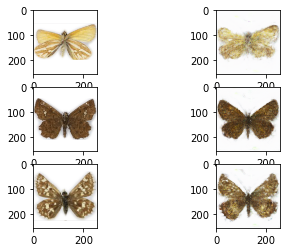

In [17]:
with tf.device(f'/device:GPU:{GPU}'):
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(321)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(322)
    plt.imshow(plot_im(x_hat[ID]))
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(323)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(324)
    plt.imshow(plot_im(x_hat[ID]))
    images = images_.next()[0]
    x_hat = reconstruct_images(images)
    ID = 2
    plt.subplot(325)
    plt.imshow(plot_im(images[ID]))
    plt.subplot(326)
    plt.imshow(plot_im(x_hat[ID]))

In [ ]:
with tf.device(f'/device:GPU:{GPU}'):
    images =  np.stack([image[0].numpy() for image in data_loader.get_plot_data()])
    images = images.reshape(len(images),256*256*4)

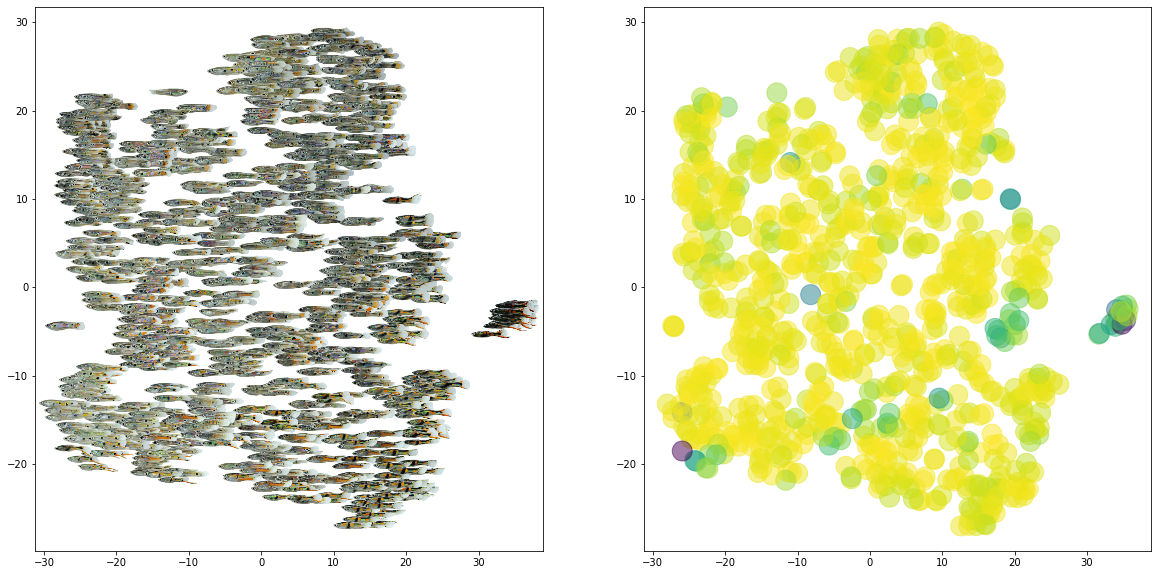

In [38]:
plt.figure(figsize=(20,10))

# classnames, indices = np.unique( labels, return_inverse=True)
# N = len(classnames)
cmap = plt.cm.viridis
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

embedding = vision_engine_embedding
plt.subplot(121)
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);

plt.subplot(122)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=lh, cmap=cmap, s=400, rasterized=True)

# plt.colorbar()
fig = plt.gcf()
fig.savefig('likelihood.pdf')

In [19]:
perception = []
with tf.device('/device:cpu:0'):
    perceptual_model = make_perceptual_loss_model((256,256,3))
    for batch in data_loader.get_test_data().batch(16):
        perception.extend(perceptual_model.predict(batch))
    perceptual_distances = calculate_perceptual_distances(np.array(perception))

In [22]:
perceptual_embedding = TSNE(callbacks=ErrorLogger(),  n_jobs=8).fit(perceptual_distances.T)
raw_image_embedding = TSNE(callbacks=ErrorLogger(), exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit()
vision_engine_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=8).fit(np.concatenate([z[0],z[1],z[2],z[3]], axis=1))
h1 = TSNE(callbacks=ErrorLogger(), n_jobs=8).fit(z[0])
h2 = TSNE(callbacks=ErrorLogger(),  n_jobs=8).fit(z[1])
h3 = TSNE(callbacks=ErrorLogger(),n_jobs=8).fit(z[2])
h4 = TSNE(callbacks=ErrorLogger(),  n_jobs=8).fit(z[3])

Iteration   50, KL divergence  4.7416, 50 iterations in 3.3448 sec
Iteration  100, KL divergence  4.5387, 50 iterations in 3.3443 sec
Iteration  150, KL divergence  4.5304, 50 iterations in 3.5511 sec
Iteration  200, KL divergence  4.5297, 50 iterations in 3.6093 sec
Iteration  250, KL divergence  4.5296, 50 iterations in 3.5623 sec
Iteration   50, KL divergence  3.0120, 50 iterations in 3.5919 sec
Iteration  100, KL divergence  2.6065, 50 iterations in 3.5409 sec
Iteration  150, KL divergence  2.3820, 50 iterations in 3.5384 sec
Iteration  200, KL divergence  2.2352, 50 iterations in 3.6282 sec
Iteration  250, KL divergence  2.1304, 50 iterations in 3.7446 sec
Iteration  300, KL divergence  2.0518, 50 iterations in 3.8072 sec
Iteration  350, KL divergence  1.9922, 50 iterations in 4.4515 sec
Iteration  400, KL divergence  1.9455, 50 iterations in 4.3460 sec
Iteration  450, KL divergence  1.9091, 50 iterations in 4.9348 sec
Iteration  500, KL divergence  1.8800, 50 iterations in 5.3412

In [22]:
with tf.device(f'/device:GPU:{GPU}'):
    labels = []
    images = []
    for image, label in data_loader.get_plot_data():
        labels.append(label.numpy().decode('utf8'))
        images.append(image.numpy().astype('uint8'))
    images = np.stack(images)
    labels = np.array(labels)

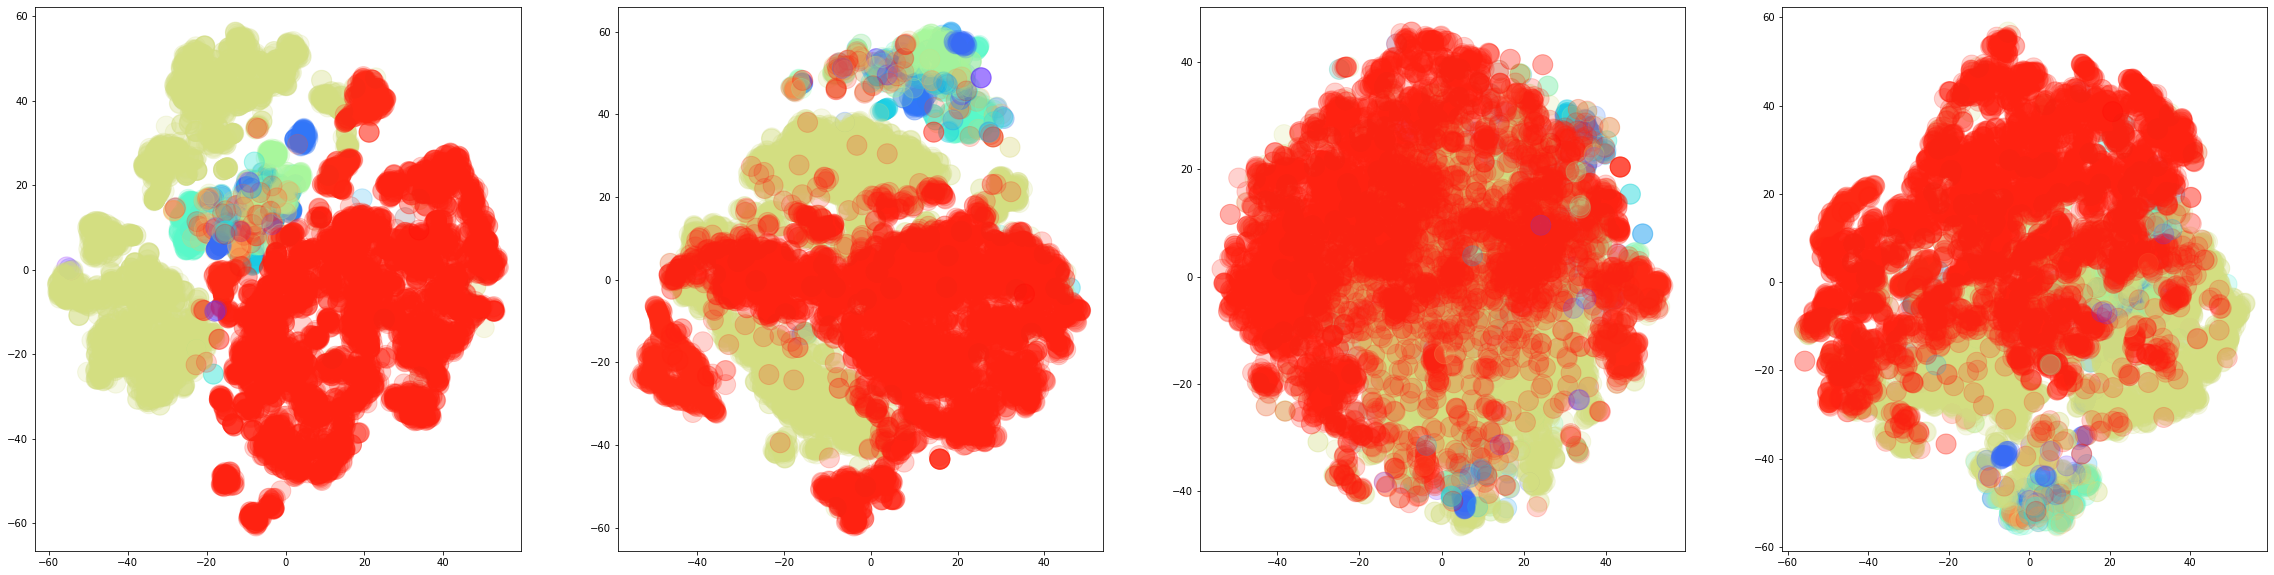

In [37]:
plt.figure(figsize=(40,10))

classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.subplot(141)
embedding = h1
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(142)
embedding = h2
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)
plt.subplot(143)
embedding = h3
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)
plt.subplot(144)
embedding = h4
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)

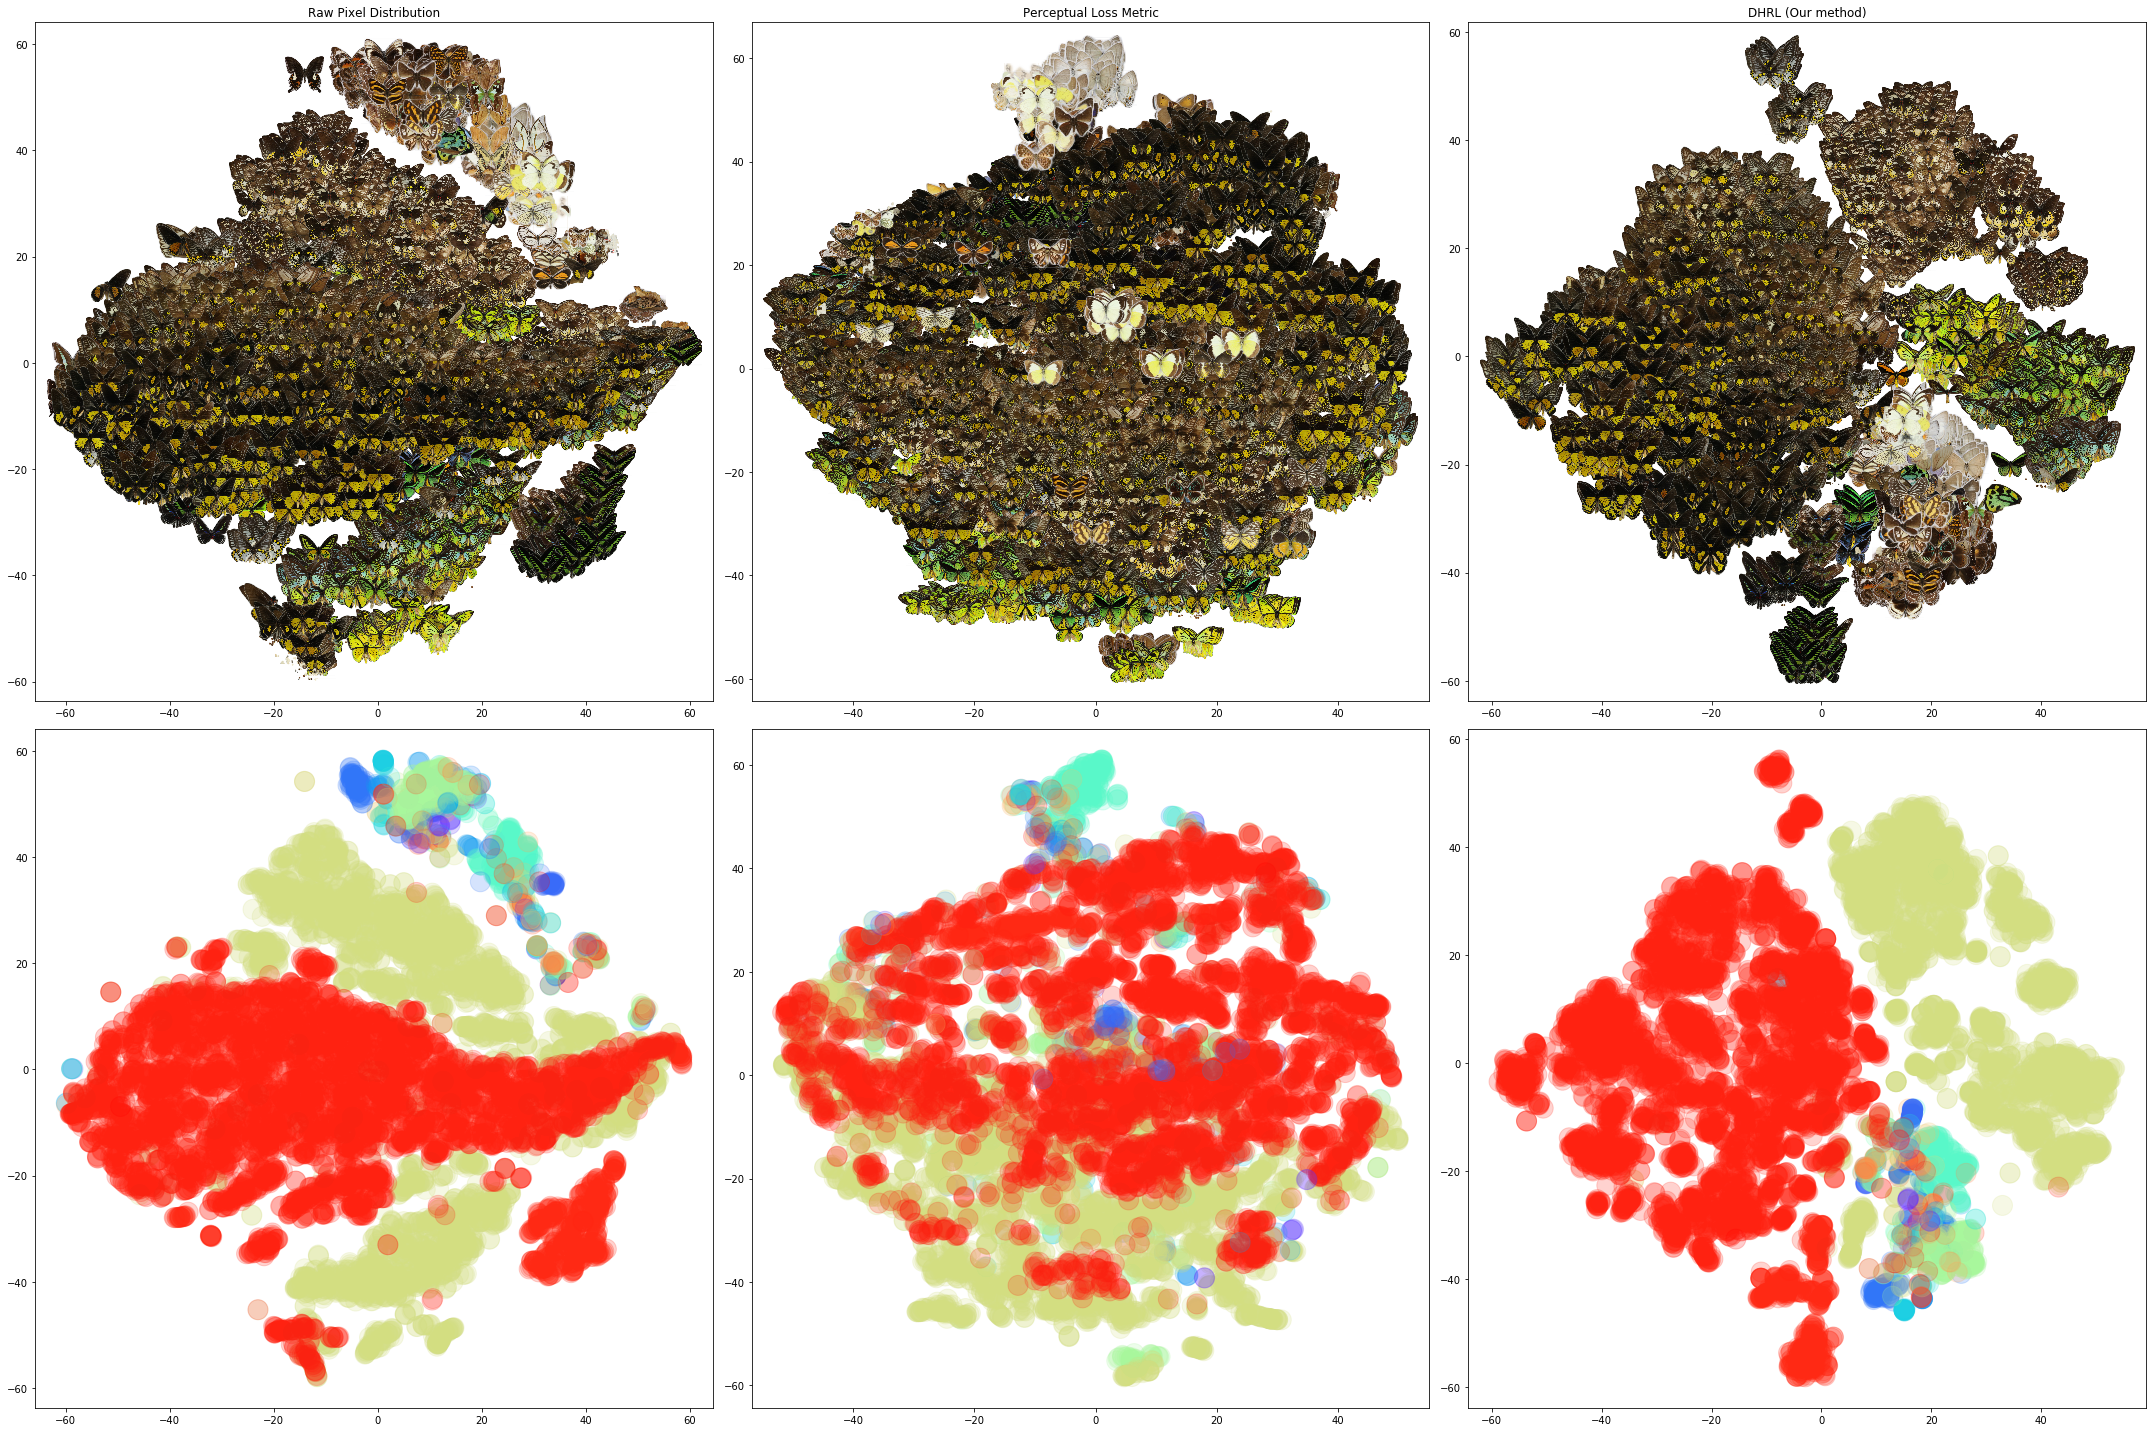

In [45]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.title('Raw Pixel Distribution')
embedding = raw_image_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(234)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.subplot(232)
plt.title('Perceptual Loss Metric')
embedding = perceptual_embedding 
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(235)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.subplot(233)
plt.title('DHRL (Our method)')
embedding = vision_engine_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(236)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.tight_layout()
fig = plt.gcf()

In [15]:
with tf.device(f'/device:GPU:{GPU}'):
    labels = np.hstack([image[1] for image in data_loader.get_test_data()])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    inputs = onehot_encoded

In [26]:
h = 3
disent_w_avg, complete_avg = dissentanglement_score(z, inputs, h)

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/VisionEngine-0.1a0-py3.7.egg/VisionEngine/utils/disentanglement_score.py:11: RuntimeWarning: invalid value encountered in true_divide


In [27]:
print(disent_w_avg, complete_avg)

0.5574085031473682 0.6640178788275946
